# BBC News classification algorithm comparison
#### Giuseppe Bonaccorso - [www.bonaccorso.eu](http://www.bonaccorso.eu)
----
News datasets (raw and preprocessed) can be downloaded from [Insight Project Resources website](http://mlg.ucd.ie/datasets/bbc.html)

Requirements: Scikit-Learn, NLTK, Gensim, Keras (with Theano or Tensorflow)

Theoricatical references:
* D. Greene and P. Cunningham. ["Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering"](http://mlg.ucd.ie/files/publications/greene06icml.pdf), Proc. ICML 2006
* Metsis, Vangelis, Ion Androutsopoulos, and Georgios Paliouras. [“Spam Filtering with Naive Bayes-Which Naive Bayes?”](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=8E082E80B04D842C58EAA12A01380139?doi=10.1.1.61.5542&rep=rep1&type=pdf), CEAS, 27–28, 2006
* Zhang, Harry. [“The Optimality of Naive Bayes.”](http://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf), AA 1, no. 2 (2004): 3
* Le, Quoc V., and Tomas Mikolov. [“Distributed Representations of Sentences and Documents”](http://www.jmlr.org/proceedings/papers/v32/le14.pdf), ICML, 14:1188–1196, 2014
* Mikolov, Tomas, Kai Chen, Greg Corrado, and Jeffrey Dean. [“Efficient Estimation of Word Representations in Vector Space”](http://arxiv.org/abs/1301.3781), arXiv Preprint arXiv:1301.3781, 2013
* Mikolov, Tomas, Ilya Sutskever, Kai Chen, Greg S. Corrado, and Jeff Dean. [“Distributed Representations of Words and Phrases and Their Compositionality”](http://papers.nips.cc/paper/5021-distributed-representations), Advances in Neural Information Processing Systems, 3111–3119, 2013
* Bonaccorso G., [Reuters-21578-Classification using Word2Vec and LSTM](https://github.com/giuseppebonaccorso/Reuters-21578-Classification)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
import glob
import multiprocessing
import time

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from keras.backend import floatx
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [3]:
# Set random seed (for reproducibility)
random.seed(1000)

bbc_news_dir = 'D:\\ml_data\\bbc\\'

bbc_news_categories = {
    'business': 1,
    'entertainment': 2,
    'politics': 3,
    'sport': 4,
    'tech': 5
}

# News data (X) and category (Y)
bbc_news_X = []
bbc_news_Y = []

# Load stop-words
stop_words = set(stopwords.words('english'))

# Initialize tokenizer
regexp_tokenizer = RegexpTokenizer('[\'a-zA-Z]+')

# Initialize lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

### Tokenize, remove stop-words and lemmatize

In [4]:
def tokenize(document, rebuild_document=True):
    words = []

    for sentence in sent_tokenize(document):
        tokens = [wordnet_lemmatizer.lemmatize(t.lower()) 
                  for t in regexp_tokenizer.tokenize(sentence) if t.lower() not in stop_words]
        words += tokens

    if rebuild_document:
        return ' '.join(words).strip()
    else:
        return words

### Import news and create train and test datasets

In [5]:
for category_label, category_idx in bbc_news_categories.iteritems():
    print('Processing category: %s (%d)' % (category_label, category_idx))
    
    for news_file_name in glob.glob(bbc_news_dir + category_label + '\\*.txt'):
        with open(news_file_name, 'r') as news_file:
            news_data = news_file.read()
        
        bbc_news_X.append(tokenize(news_data.decode('ISO-8859-1')))
        bbc_news_Y.append(category_idx)
        
print('Corpus size: %d' % len(bbc_news_X))

# Split the whole corpus in train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(bbc_news_X, bbc_news_Y, test_size=0.25)

Processing category: politics (3)
Processing category: sport (4)
Processing category: tech (5)
Processing category: business (1)
Processing category: entertainment (2)
Corpus size: 2225


### Support functions and data

In [6]:
precisions_micro = []
precisions_macro = []
recalls_micro = []
recalls_macro = []
f1s_micro = []
f1s_macro = []

def plot_confusion_matrix(Y_test, Y_pred):
    cmatrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
    cm_fig, cm_ax = subplots(figsize=(8.0, 8.0))
    cm_ax.matshow(cmatrix, cmap=cm.GnBu)

    cm_ax.set_xticklabels([''] + bbc_news_categories.keys())
    cm_ax.set_yticklabels([''] + bbc_news_categories.keys())

    for i in range(len(bbc_news_categories.keys())):
        for j in range(len(bbc_news_categories.keys())):
            cm_ax.text(x=j, y=i, s=cmatrix[i, j], va='center', ha='center')

    title('Confusion matrix')
    xlabel('Predicted categories')
    ylabel('Actual categories')

## Naive Bayes approach

### Multinomial with Count Vectorizer

In [37]:
count_vectorizer = CountVectorizer()
multinomialNB = MultinomialNB()

# Define pipeline
mn_cv_nb_pipeline = Pipeline([('vectorizer', count_vectorizer),
                             ('multinomial_nb', multinomialNB)])

# Grid search parameters
mn_cv_nb_param_grid = [
    { 
        'vectorizer__min_df': [ 1, 2, 3, 4, 5 ],
        'vectorizer__ngram_range': [ (1, 1), (1, 2), (1, 3) ],
        'multinomial_nb__alpha': [ 0.0, 0.25, 0.5, 0.75, 1.0 ]
    }
]

# Perform grid search
mn_cv_nb_gs = GridSearchCV(estimator=mn_cv_nb_pipeline, param_grid=mn_cv_nb_param_grid, 
                           scoring='accuracy', cv=25, n_jobs=multiprocessing.cpu_count())

mn_cv_nb_gs.fit(X_train, Y_train)

# Create an instance of the best estimator
mn_cv_nb_best = mn_cv_nb_gs.best_estimator_
mn_cv_nb_best.fit(X_train, Y_train)

print('Best model: %s' % str(mn_cv_nb_gs.best_params_))
print('Best score: %f' % mn_cv_nb_gs.best_score_)
print('Best test accuracy: %f' % mn_cv_nb_best.score(X_test, Y_test))

Best model: {'vectorizer__min_df': 2, 'multinomial_nb__alpha': 0.25, 'vectorizer__ngram_range': (1, 2)}
Best score: 0.979017
Best test accuracy: 0.987433


### Best model evaluation

Precision score: 0.987433 (micro) / 0.986406 (macro)
Recall score: 0.987433 (micro) / 0.987845 (macro)
F1 score: 0.987433 (micro) / 0.986997 (macro)


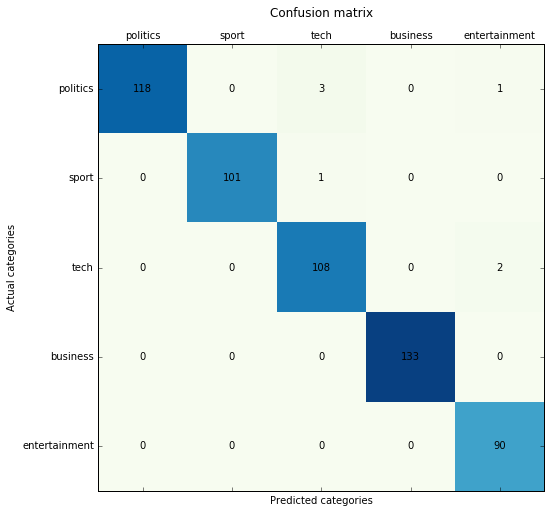

In [51]:
mn_cv_nb_Y_pred = mn_cv_nb_best.predict(X_test)

# Compute precision, recall and F1 scores with micro and macro averaging
mn_cv_nb_precision_micro = precision_score(y_true=Y_test, y_pred=mn_cv_nb_Y_pred, average='micro')
mn_cv_nb_precision_macro = precision_score(y_true=Y_test, y_pred=mn_cv_nb_Y_pred, average='macro')
mn_cv_nb_recall_micro = recall_score(y_true=Y_test, y_pred=mn_cv_nb_Y_pred, average='micro')
mn_cv_nb_recall_macro = recall_score(y_true=Y_test, y_pred=mn_cv_nb_Y_pred, average='macro')
mn_cv_nb_f1_micro = f1_score(y_true=Y_test, y_pred=mn_cv_nb_Y_pred, average='micro')
mn_cv_nb_f1_macro = f1_score(y_true=Y_test, y_pred=mn_cv_nb_Y_pred, average='macro')

precisions_micro.append(mn_cv_nb_precision_micro)
precisions_macro.append(mn_cv_nb_precision_macro)
recalls_micro.append(mn_cv_nb_recall_micro)
recalls_macro.append(mn_cv_nb_recall_macro)
f1s_micro.append(mn_cv_nb_f1_micro)
f1s_macro.append(mn_cv_nb_f1_macro)

print('Precision score: %f (micro) / %f (macro)' % (mn_cv_nb_precision_micro, mn_cv_nb_precision_macro))
print('Recall score: %f (micro) / %f (macro)' % (mn_cv_nb_recall_micro, mn_cv_nb_recall_macro))
print('F1 score: %f (micro) / %f (macro)' % (mn_cv_nb_f1_micro, mn_cv_nb_f1_macro))

# Compute confusion matrix
plot_confusion_matrix(Y_test, mn_cv_nb_Y_pred)

### Multinomial with Tf-Idf Vectorizer

In [52]:
tfidf_vectorizer = TfidfVectorizer()
multinomialNB = MultinomialNB()

# Define pipeline
mn_tfidfv_nb_pipeline = Pipeline([('vectorizer', tfidf_vectorizer),
                             ('multinomial_nb', multinomialNB)])

# Grid search parameters
mn_tfidfv_nb_param_grid = [
    { 
        'vectorizer__min_df': [ 1, 2, 3, 4, 5 ],
        'vectorizer__ngram_range': [ (1, 1), (1, 2), (1, 3) ],
        'vectorizer__norm': [ None, 'l1', 'l2' ],
        'vectorizer__smooth_idf': [True, False],
        'multinomial_nb__alpha': [ 0.0, 0.25, 0.5, 0.75, 1.0 ]
    }
]

# Perform grid search
mn_tfidfv_nb_gs = GridSearchCV(estimator=mn_tfidfv_nb_pipeline, param_grid=mn_tfidfv_nb_param_grid, 
                           scoring='accuracy', cv=25, n_jobs=multiprocessing.cpu_count())

mn_tfidfv_nb_gs.fit(X_train, Y_train)

# Create an instance of the best estimator
mn_tfidfv_nb_best = mn_tfidfv_nb_gs.best_estimator_
mn_tfidfv_nb_best.fit(X_train, Y_train)

print('Best model: %s' % str(mn_tfidfv_nb_gs.best_params_))
print('Best score: %f' % mn_tfidfv_nb_gs.best_score_)
print('Best test accuracy: %f' % mn_tfidfv_nb_best.score(X_test, Y_test))

Best model: {'vectorizer__min_df': 1, 'multinomial_nb__alpha': 0.5, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': None, 'vectorizer__smooth_idf': True}
Best score: 0.981415
Best test accuracy: 0.980251


### Best model evaluation

Precision score: 0.980251 (micro) / 0.978598 (macro)
Recall score: 0.980251 (micro) / 0.980466 (macro)
F1 score: 0.980251 (micro) / 0.979228 (macro)


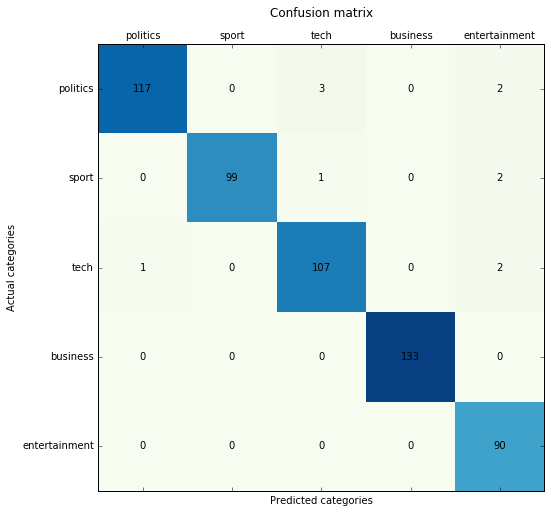

In [53]:
mn_tfidfv_nb_Y_pred = mn_tfidfv_nb_best.predict(X_test)

# Compute precision, recall and F1 scores with micro and macro averaging
mn_tfidfv_nb_precision_micro = precision_score(y_true=Y_test, y_pred=mn_tfidfv_nb_Y_pred, average='micro')
mn_tfidfv_nb_precision_macro = precision_score(y_true=Y_test, y_pred=mn_tfidfv_nb_Y_pred, average='macro')
mn_tfidfv_nb_recall_micro = recall_score(y_true=Y_test, y_pred=mn_tfidfv_nb_Y_pred, average='micro')
mn_tfidfv_nb_recall_macro = recall_score(y_true=Y_test, y_pred=mn_tfidfv_nb_Y_pred, average='macro')
mn_tfidfv_nb_f1_micro = f1_score(y_true=Y_test, y_pred=mn_tfidfv_nb_Y_pred, average='micro')
mn_tfidfv_nb_f1_macro = f1_score(y_true=Y_test, y_pred=mn_tfidfv_nb_Y_pred, average='macro')

precisions_micro.append(mn_tfidfv_nb_precision_micro)
precisions_macro.append(mn_tfidfv_nb_precision_macro)
recalls_micro.append(mn_tfidfv_nb_recall_micro)
recalls_macro.append(mn_tfidfv_nb_recall_macro)
f1s_micro.append(mn_tfidfv_nb_f1_micro)
f1s_macro.append(mn_tfidfv_nb_f1_macro)

print('Precision score: %f (micro) / %f (macro)' % (mn_tfidfv_nb_precision_micro, mn_tfidfv_nb_precision_macro))
print('Recall score: %f (micro) / %f (macro)' % (mn_tfidfv_nb_recall_micro, mn_tfidfv_nb_recall_macro))
print('F1 score: %f (micro) / %f (macro)' % (mn_tfidfv_nb_f1_micro, mn_tfidfv_nb_f1_macro))

# Compute confusion matrix
plot_confusion_matrix(Y_test, mn_tfidfv_nb_Y_pred)

## Doc2Vec (Gensim-based) approach
See [Gensim website](https://radimrehurek.com/gensim/) for further information

In [11]:
# Create tagged documents
bbc_news_tagged_documents = []

for i, document in enumerate(bbc_news_X):
    bbc_news_tagged_documents.append(TaggedDocument(document.split(' '), [i]))
    
# Train Doc2Vec
doc2vec_vector_size = 50

doc2vec_model = Doc2Vec(documents=bbc_news_tagged_documents, size=doc2vec_vector_size, window=3, 
                        min_count=2, iter=30, workers=multiprocessing.cpu_count())
doc2vec_model.init_sims(replace=False)

# Vectorize documents and split the whole corpus in train and test sets
bbc_news_vectors = []

for document in bbc_news_X:
    bbc_news_vectors.append(doc2vec_model.infer_vector(document.split(' ')))

d2v_X_train, d2v_X_test, d2v_Y_train, d2v_Y_test = train_test_split(bbc_news_vectors, bbc_news_Y, test_size=0.25)

### Support Vector Machines (Linear and Kernel-based)

In [19]:
scaler = StandardScaler()
svc = SVC()

# Define pipeline
svc_d2v_pipeline = Pipeline([('scaler', scaler),
                             ('svc', svc)])

# Grid search parameters
svc_d2v_param_grid = [
    { 
        'svc__kernel': [ 'linear' ],
        'svc__C': [0.5, 1.0, 5.0, 10.0 ]
    },
    { 
        'svc__kernel': [ 'poly' ],
        'svc__C': [0.5, 1.0, 5.0, 10.0 ]
    },
    { 
        'svc__kernel': [ 'rbf' ],
        'svc__C': [0.5, 1.0, 5.0, 10.0 ]
    }
]

# Perform grid search
svc_d2v_gs = GridSearchCV(estimator=svc_d2v_pipeline, param_grid=svc_d2v_param_grid, 
                           scoring='accuracy', cv=25, n_jobs=multiprocessing.cpu_count())

svc_d2v_gs.fit(d2v_X_train, d2v_Y_train)

# Create an instance of the best estimator
svc_d2v_best = svc_d2v_gs.best_estimator_
svc_d2v_best.fit(d2v_X_train, d2v_Y_train)

print('Best model: %s' % str(svc_d2v_gs.best_params_))
print('Best score: %f' % svc_d2v_gs.best_score_)
print('Best test accuracy: %f' % svc_d2v_best.score(X_test, Y_test))

Best model: {'svc__kernel': 'rbf', 'svc__C': 5.0}
Best score: 0.968825
Best test accuracy: 0.980251


### Best model evaluation

Precision score: 0.987433 (micro) / 0.987537 (macro)
Recall score: 0.987433 (micro) / 0.987811 (macro)
F1 score: 0.987433 (micro) / 0.987666 (macro)


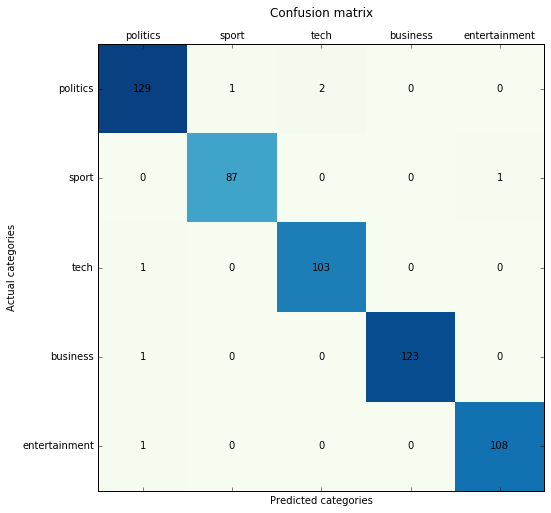

In [24]:
svc_d2v_Y_pred = svc_d2v_best.predict(d2v_X_test)

# Compute precision, recall and F1 scores with micro and macro averaging
svc_d2v_precision_micro = precision_score(y_true=d2v_Y_test, y_pred=svc_d2v_Y_pred, average='micro')
svc_d2v_precision_macro = precision_score(y_true=d2v_Y_test, y_pred=svc_d2v_Y_pred, average='macro')
svc_d2v_recall_micro = recall_score(y_true=d2v_Y_test, y_pred=svc_d2v_Y_pred, average='micro')
svc_d2v_recall_macro = recall_score(y_true=d2v_Y_test, y_pred=svc_d2v_Y_pred, average='macro')
svc_d2v_f1_micro = f1_score(y_true=d2v_Y_test, y_pred=svc_d2v_Y_pred, average='micro')
svc_d2v_f1_macro = f1_score(y_true=d2v_Y_test, y_pred=svc_d2v_Y_pred, average='macro')

precisions_micro.append(svc_d2v_precision_micro)
precisions_macro.append(svc_d2v_precision_macro)
recalls_micro.append(svc_d2v_recall_micro)
recalls_macro.append(svc_d2v_recall_macro)
f1s_micro.append(svc_d2v_f1_micro)
f1s_macro.append(svc_d2v_f1_macro)

print('Precision score: %f (micro) / %f (macro)' % (svc_d2v_precision_micro, svc_d2v_precision_macro))
print('Recall score: %f (micro) / %f (macro)' % (svc_d2v_recall_micro, svc_d2v_recall_macro))
print('F1 score: %f (micro) / %f (macro)' % (svc_d2v_f1_micro, svc_d2v_f1_macro))

# Compute confusion matrix
plot_confusion_matrix(d2v_Y_test, svc_d2v_Y_pred)

### Multi-layer Perceptron (Keras-based) approach
See [Keras website](https://keras.io/) for further information

In [15]:
# Create MLP
def build_mlp(hidden_layer_1_size=32, hidden_layer_2_size=16, dropout_1_2=0.1):
    mlp_model = Sequential()

    mlp_model.add(Dense(hidden_layer_1_size, input_dim=doc2vec_vector_size, activation='tanh'))
    
    if dropout_1_2 > 0.0:
        mlp_model.add(Dropout(dropout_1_2))
    
    if hidden_layer_2_size > 0:
        mlp_model.add(Dense(hidden_layer_2_size, activation='tanh'))
        
    mlp_model.add(Dense(len(bbc_news_categories.keys()), activation='softmax'))

    mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return mlp_model

In [47]:
# Convert classes to categories (0, 1, 2, 3, 4)
bbc_news_Y_n = map(lambda x: x - 1, bbc_news_Y)

# Split the whole corpus in train and test sets
scaler = StandardScaler()
mlp_X_train, mlp_X_test, mlp_Y_train, mlp_Y_test = train_test_split(scaler.fit_transform(bbc_news_vectors), 
                                                                    array(bbc_news_Y_n).astype(floatx()), test_size=0.25)

# Create scaler and Keras-Scikit-Learn classifier
mlp_classifier = KerasClassifier(build_mlp, verbose=0, hidden_layer_1_size=32, hidden_layer_2_size=16, dropout_1_2=0.1)

# Grid search parameters
mlp_param_grid = [
    { 
        'verbose': [ 0 ],
        'batch_size': [ 8, 16, 32 ],
        'nb_epoch': [ 10, 20, 30, 50 ],
        'hidden_layer_1_size': [ 64, 32, 16 ],
        'hidden_layer_2_size': [ 32, 16, 8, 0 ],
        'dropout_1_2': [ 0.0, 0.1, 0.25 ]        
    }
]

# Perform grid search
mlp_gs = GridSearchCV(estimator=mlp_classifier, param_grid=mlp_param_grid, scoring='accuracy', cv=25, n_jobs=1)
mlp_gs.fit(array(mlp_X_train).astype(floatx()), mlp_Y_train)

# Create an instance of the best estimator
mlp_best = mlp_gs.best_estimator_
mlp_best.fit(array(mlp_X_train).astype(floatx()), mlp_Y_train)

print('Best model: %s' % str(mlp_gs.best_params_))
print('Best score: %f' % mlp_gs.best_score_)
print('Best test accuracy: %f' % mlp_best.score(array(mlp_X_test).astype(floatx()), mlp_Y_test))

Best model: {'dropout_1_2': 0.0, 'nb_epoch': 30, 'batch_size': 8, 'hidden_layer_2_size': 16, 'hidden_layer_1_size': 32, 'verbose': 0}
Best score: 0.968825
Best test accuracy: 0.956912


### Best model evaluation

Precision score: 0.985637 (micro) / 0.984715 (macro)
Recall score: 0.985637 (micro) / 0.986193 (macro)
F1 score: 0.985637 (micro) / 0.985397 (macro)


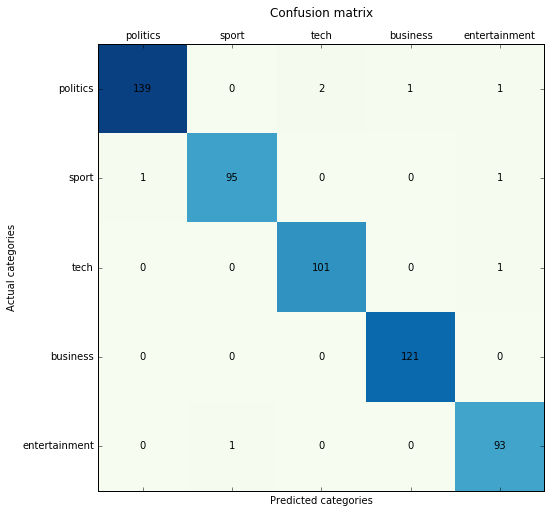

In [48]:
mlp_Y_pred = mlp_best.predict(array(mpl_X_test).astype(floatx()))

# Compute precision, recall and F1 scores with micro and macro averaging
mlp_precision_micro = precision_score(y_true=mpl_Y_test, y_pred=mlp_Y_pred, average='micro')
mlp_precision_macro = precision_score(y_true=mpl_Y_test, y_pred=mlp_Y_pred, average='macro')
mlp_recall_micro = recall_score(y_true=mpl_Y_test, y_pred=mlp_Y_pred, average='micro')
mlp_recall_macro = recall_score(y_true=mpl_Y_test, y_pred=mlp_Y_pred, average='macro')
mlp_f1_micro = f1_score(y_true=mpl_Y_test, y_pred=mlp_Y_pred, average='micro')
mlp_f1_macro = f1_score(y_true=mpl_Y_test, y_pred=mlp_Y_pred, average='macro')

precisions_micro.append(mlp_precision_micro)
precisions_macro.append(mlp_precision_macro)
recalls_micro.append(mlp_recall_micro)
recalls_macro.append(mlp_recall_macro)
f1s_micro.append(mlp_f1_micro)
f1s_macro.append(mlp_f1_macro)

print('Precision score: %f (micro) / %f (macro)' % (mlp_precision_micro, mlp_precision_macro))
print('Recall score: %f (micro) / %f (macro)' % (mlp_recall_micro, mlp_recall_macro))
print('F1 score: %f (micro) / %f (macro)' % (mlp_f1_micro, mlp_f1_macro))

# Compute confusion matrix
plot_confusion_matrix(map(lambda x: x + 1, mpl_Y_test), map(lambda x: x + 1, mlp_Y_pred))

## Performance comparison

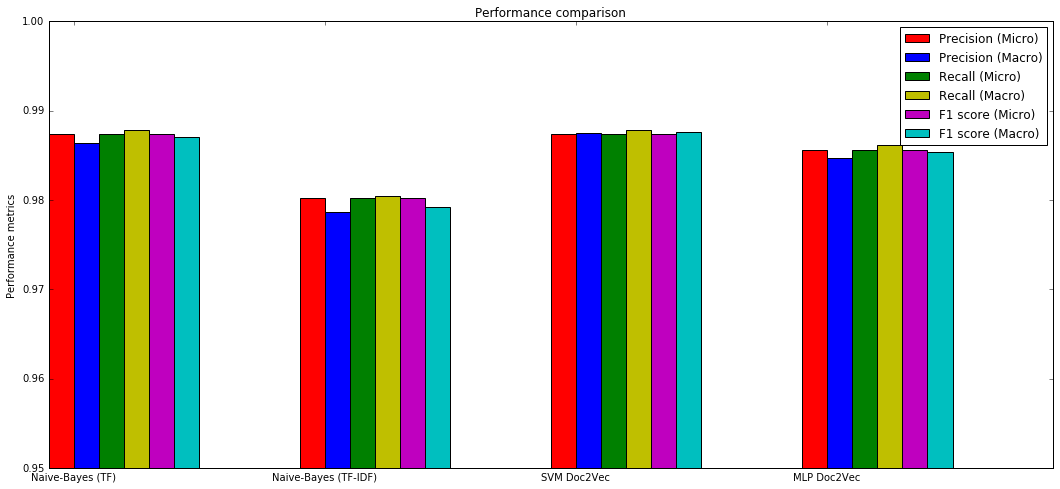

In [54]:
cmp_fig, cmp_ax = subplots(figsize=(18.0, 8.0))

pmicro = cmp_ax.bar(arange(4), precisions_micro, 0.1, color='r')
pmacro = cmp_ax.bar(arange(4) + 0.1, precisions_macro, 0.1, color='b')
rmicro = cmp_ax.bar(arange(4) + (2 * 0.1), recalls_micro, 0.1, color='g')
rmacro = cmp_ax.bar(arange(4) + (3 * 0.1), recalls_macro, 0.1, color='y')
f1micro = cmp_ax.bar(arange(4) + (4 * 0.1), f1s_micro, 0.1, color='m')
f1macro = cmp_ax.bar(arange(4) + (5 * 0.1), f1s_macro, 0.1, color='c')

cmp_ax.set_ylabel('Performance metrics')
cmp_ax.set_title('Performance comparison')

cmp_ax.set_xticks(arange(4) + 0.1)
cmp_ax.set_ylim([0.95, 1.0])

cmp_ax.set_xticklabels(('Naive-Bayes (TF)', 'Naive-Bayes (TF-IDF)', 'SVM Doc2Vec', 'MLP Doc2Vec'))

cmp_ax.legend((pmicro[0], pmacro[0], rmicro[0], rmacro[0], f1micro[0], f1macro[0]), 
              ('Precision (Micro)', 'Precision (Macro)',
               'Recall (Micro)', 'Recall (Macro)',
               'F1 score (Micro)', 'F1 score (Macro)'))